### Baseic neural network

In [1]:
# IMPORT
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statistics

In [2]:
# READ DATA FROM CSV AND CONVERT INTO DATAFRAME
data = pd.read_csv('Anger.csv')
data.rename(columns={'Unnamed: 0':'ID'},inplace=True)
data['ID']=data['ID'].str[1:]
data=data.drop(columns="Video")
data.at[data['Label'] == 'Genuine', ['Label']] = 0
data.at[data['Label'] == 'Posed', ['Label']] = 1
data = data.apply(pd.to_numeric)

In [3]:
# NORMALIZE DATAFRAME USING THE FORMULA GIVEN IN THE LAB
for column in data.columns[:-1]:
    data[column] = data.loc[:, [column]].apply(lambda x: (x - x.min()) / (x.max()- x.min()))

In [4]:
# DIVIDE INTO INPUT AND OUTPUT
data_X = data.iloc[:, 1:7]
data_Y = data.iloc[:, 7:]

In [5]:
# SPLIT INTO TEST AND TRAIING DATA USING TEST SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=0)

x_array = X_train.values
x1_array = X_test.values
y_array = np.array([i[0] for i in y_train.values])
y1_array = np.array([i[0] for i in y_test.values])


In [6]:
X = torch.tensor(x_array, dtype=torch.float)
Y = torch.tensor(y_array, dtype=torch.long)
X1 = torch.tensor(x1_array, dtype=torch.float)
Y1 = torch.tensor(y1_array, dtype=torch.long)

In [7]:
# PARAMETER FOR NERUAL NETWORK
input_neurons = 6
hidden_neurons = 20
output_neurons = 2
learning_rate = 0.005  #0.005 for better result, remember to changed the one after
num_epoch = 1000

In [8]:
# ACCURACY SCORE LIST FOR EACH RUN
acclist=[]
testlist=[]
# LOSS LIST FOR EACH RUN
losslist=[]
trainacclist=[]
# RUN 10 TIMES FOR AVERAGE SCORE
for run in range(10):
    trainacclist.append([])
    testlist.append([])
    net = torch.nn.Sequential(
        torch.nn.Linear(input_neurons, hidden_neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_neurons, output_neurons),
    )

    # define loss functions
    loss_func = torch.nn.CrossEntropyLoss()

    # define optimiser
    optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # store all losses for visualisation
    all_losses = []
    # train a neural network
    for epoch in range(num_epoch):
        # Perform forward pass: compute predicted y by passing x to the model.
        # Here we pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        # In this case, Y_pred contains three columns, where the index of the
        # max column indicates the class of the instance
        Y_pred = net(X)
        # Compute loss
        # Here we pass Tensors containing the predicted and true values of Y,
        # and the loss function returns a Tensor containing the loss.
        loss = loss_func(Y_pred, Y)
        all_losses.append(loss.item())
        # print progress
#         if epoch % 50 == 0:
            # convert three-column predicted Y values to one column for comparison
        raw_pred, predicted = torch.max(F.softmax(Y_pred,1), 1)

        total = predicted.size(0)
        correct = predicted.data.numpy() == Y.data.numpy()
#             print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
#                   % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))

        # Clear the gradients before running the backward pass.
        net.zero_grad()
        trainacclist[run].append(sum(correct)/total)
        # Perform backward pass: compute gradients of the loss with respect to
        # all the learnable parameters of the model.
        loss.backward()

        # Calling the step function on an Optimiser makes an update to its
        # parameters
        optimiser.step()
        Y_pred = net(X1)
        _, predicted = torch.max(F.softmax(Y_pred,1), 1)
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y1.data.numpy()
        testlist[run].append(sum(correct)/total)
        
    Y_pred = net(X1)

    # Compute loss
    # Here we pass Tensors containing the predicted and true values of Y,
    # and the loss function returns a Tensor containing the loss.
    losslist.append(all_losses)
    _, predicted = torch.max(F.softmax(Y_pred,1), 1)
    # calculate and print accuracy
    total = predicted.size(0)
    correct = predicted.data.numpy() == Y1.data.numpy()
    acclist.append(sum(correct)/total)
    print('Normal backprogation result Accuracy: %.2f %%'
          % (100 * sum(correct)/total))
print("Average accuracy: %.6f"%(sum(acclist)/len(acclist)))

Normal backprogation result Accuracy: 67.50 %
Normal backprogation result Accuracy: 70.00 %
Normal backprogation result Accuracy: 70.00 %
Normal backprogation result Accuracy: 73.75 %
Normal backprogation result Accuracy: 67.50 %
Normal backprogation result Accuracy: 71.25 %
Normal backprogation result Accuracy: 68.75 %
Normal backprogation result Accuracy: 66.25 %
Normal backprogation result Accuracy: 68.75 %
Normal backprogation result Accuracy: 70.00 %
Average accuracy: 0.693750


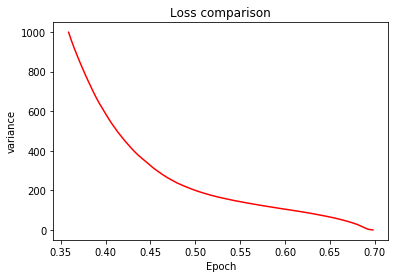

In [9]:
fig, ax = plt.subplots()
a=np.mean(np.array(losslist), axis=0)
plt.plot(a,range(len(a)),c='r')
plt.xlabel('Epoch')
plt.ylabel('variance')
plt.title('Loss comparison')
plt.show()

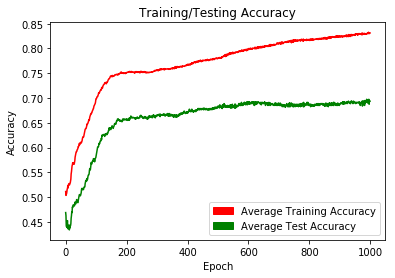

In [10]:
fig, ax = plt.subplots()
a=np.mean(np.array(trainacclist), axis=0)
b=np.mean(np.array(testlist), axis=0)
plt.plot(range(len(a)),a,c='r')
plt.plot(range(len(b)),b,c='g')
plt.xlabel('Epoch') 
# ax.axhline(y=sum(acclist)/len(acclist))
        
patch1 = matplotlib.patches.Patch(color='r', label='Average Training Accuracy')
patch2 = matplotlib.patches.Patch(color='g', label='Average Test Accuracy')
plt.legend(handles=[patch1,patch2])
# fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Accuracy')
plt.title('Training/Testing Accuracy')
plt.show()

### Neural network with BDR
This file read in the data and divide the data randomly into test data and train data with the ratio of 8:2.
It then apply BDR on ONLY TRAINING dataset and using the new training set to do normal back propagation.


In [11]:
# SPLIT INTO TEST AND TRAIING DATA USING TEST SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.2, random_state=0)

x_array = X_train.values
x1_array = X_test.values
y_array = np.array([i[0] for i in y_train.values])
y1_array = np.array([i[0] for i in y_test.values])


In [12]:
# define the number of neurons for input layer, hidden layer and output layer
# define learning rate and number of epoch on training
input_neurons = 6
hidden_neurons = 20
output_neurons = 2
learning_rate = 0.005
num_epoch = 1000
alpha_value=0.5

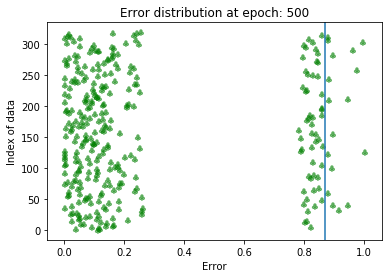

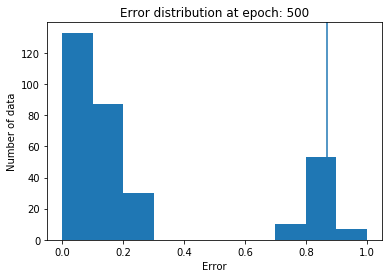

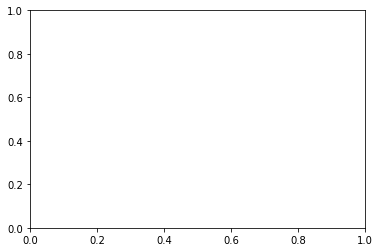

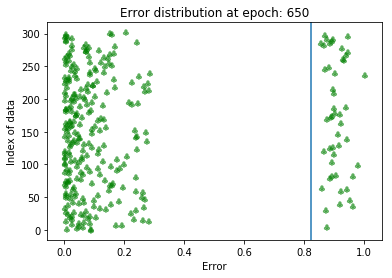

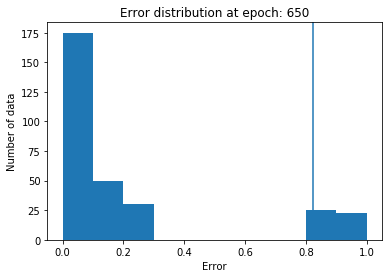

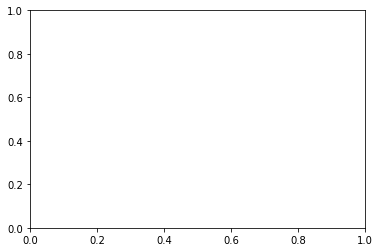

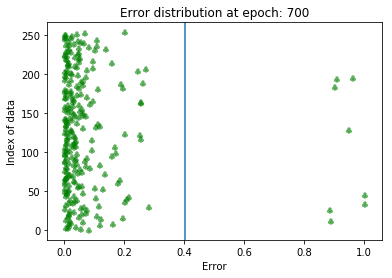

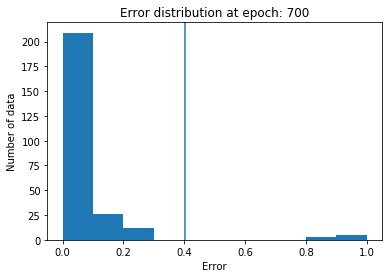

Normal backprogation result Accuracy: 70.00 %
Average accuracy: 0.70


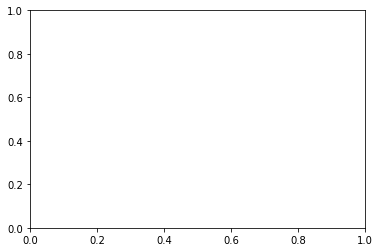

In [13]:
# ACCURACY SCORE LIST FOR EACH RUN
acclist2=[]
all_vari2=[]
# LOSS LIST FOR EACH RUN
losslist2=[]
trainacclist2=[]
errdistribute2=[]
triggerpoint=[]
testlist2=[]
# RUN 10 TIMES FOR AVERAGE SCORE
for run in range(1):
    
    X = torch.tensor(x_array, dtype=torch.float)
    Y = torch.tensor(y_array, dtype=torch.long)
    X1 = torch.tensor(x1_array, dtype=torch.float)
    Y1 = torch.tensor(y1_array, dtype=torch.long)
    trainacclist2.append([])
    testlist2.append([])
    net = torch.nn.Sequential(
        torch.nn.Linear(input_neurons, hidden_neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_neurons, output_neurons),
    )

    # define loss functions
    loss_func = torch.nn.CrossEntropyLoss()

    # define optimiser
    optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # store all losses for visualisation
    all_losses = []
    # train a neural network
    for epoch in range(num_epoch):
        # Perform forward pass: compute predicted y by passing x to the model.
        # Here we pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        # In this case, Y_pred contains three columns, where the index of the
        # max column indicates the class of the instance
        Y_pred = net(X)
        # Compute loss
        # Here we pass Tensors containing the predicted and true values of Y,
        # and the loss function returns a Tensor containing the loss.
        loss = loss_func(Y_pred, Y)

        all_losses.append(loss.item())

        # print progress

        # convert three-column predicted Y values to one column for comparison
        raw_pred, predicted = torch.max(F.softmax(Y_pred,1), 1)

        # calculate and print accuracy
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y.data.numpy()
        pred=[i.item() for i in raw_pred]
##         Compute error
#         x=np.array([[1-abs(pred[i])] if correct[i] else [abs(pred[i])] for i in range(len(correct))])  # 1 - the probability of choosing correct output
       
        x=np.array([[-abs(pred[i])] if correct[i] else [abs(pred[i])] for i in range(len(correct))])

        trainacclist2[run].append(sum(correct)/total)

        df = pd.DataFrame(x*1)
        for column in df.columns:
            df[column] = df.loc[:, [column]].apply(lambda x: (x - x.min()) / (x.max()- x.min()))
    #         df[column] = df.loc[:, [column]].apply(lambda x: (x - x.mean()) / x.std())
        errorlist=[i for i in df[0].values]
        errdistribute2.append(errorlist)
        vari=np.var(errorlist)
        all_vari2.append(vari)

        if vari<=0.01:
#             print("<=0.01 Stop trigger at: ",epoch)
            break
        if (epoch) % 50 == 0:
#             print("variance:",vari)
            if vari<0.1:
#                 print("<0.1 trigger at: ",epoch)
                triggerpoint.append((vari,epoch))
                meanerror=np.mean(errorlist)
                masklist=[]
    #             masklist=[0 if i>meanerror else 1 for i in errorlist]
                sublist=[i if i>meanerror else 0 for i in errorlist]
                sublist_cal=[i for i in errorlist if i>meanerror]
                sublist_cal_mean=np.mean(np.array(sublist_cal))
                sublist_cal_std=np.std(np.array(sublist_cal))
    #             print(sublist_cal)
                for i in range(len(errorlist)):
                    if errorlist[i]>=sublist_cal_mean+alpha_value*sublist_cal_std:
                        masklist.append(0)
                    else:
                        masklist.append(1)

                fig, ax = plt.subplots()
                plt.scatter( errorlist,[i for i in range(len(errorlist))], c="g", alpha=0.5, marker=r'$\clubsuit$',label="Luck")
                ax.axvline(x=sublist_cal_mean+alpha_value*sublist_cal_std)
                plt.title('Error distribution at epoch: '+str(epoch))
                plt.xlabel('Error')
                plt.ylabel('Index of data')
                plt.show()
                fig, ax = plt.subplots()
                plt.hist(errorlist)
                ax.axvline(x=sublist_cal_mean+alpha_value*sublist_cal_std)
                plt.xlabel('Error')
                plt.ylabel('Number of data')
                plt.title('Error distribution at epoch: '+str(epoch))
                plt.show()
                fig, ax = plt.subplots()
                loc = torch.ByteTensor(masklist)
#                 break
                X = X[loc]
                Y = Y[loc]
                normalized_test_Y=[i.item() for i in Y]
#                 print("new X list length: ",len(X))

#             print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
#               % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))


        # Clear the gradients before running the backward pass.
        net.zero_grad()

        # Perform backward pass: compute gradients of the loss with respect to
        # all the learnable parameters of the model.
        loss.backward()

        # Calling the step function on an Optimiser makes an update to its
        # parameters
        optimiser.step()
        Y_pred = net(X1)

        _, predicted = torch.max(F.softmax(Y_pred,1), 1)
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y1.data.numpy()
        testlist2[run].append(sum(correct)/total)
    Y_pred = net(X1)

    # Compute loss
    # Here we pass Tensors containing the predicted and true values of Y,
    # and the loss function returns a Tensor containing the loss.
    losslist2.append(all_losses)
    _, predicted = torch.max(F.softmax(Y_pred,1), 1)
    # calculate and print accuracy
    total = predicted.size(0)
    correct = predicted.data.numpy() == Y1.data.numpy()
    acclist2.append(sum(correct)/total)
    len(X)
    print('Normal backprogation result Accuracy: %.2f %%'
          % (100 * sum(correct)/total))
print("Average accuracy: %.6f"%(sum(acclist2)/len(acclist2)))

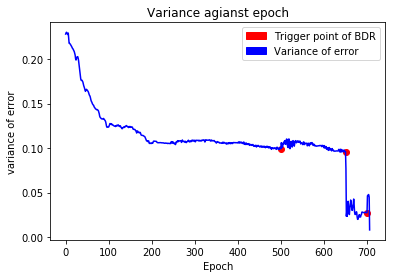

In [14]:
fig, ax = plt.subplots()
plt.plot(all_vari2,c='b')
xxx=[]
yyy=[]
for a,b in triggerpoint:
    xxx.append(a)
    yyy.append(b)
plt.scatter(yyy,xxx,c='r')
plt.xlabel('Epoch')
plt.ylabel('variance of error')
plt.title('Variance agianst epoch')
patch1 = matplotlib.patches.Patch(color='r', label='Trigger point of BDR')
patch2 = matplotlib.patches.Patch(color='b', label='Variance of error')
plt.legend(handles=[patch1,patch2])
# fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

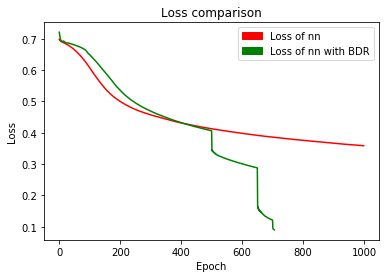

In [15]:
fig, ax = plt.subplots()
a=np.mean(np.array(losslist), axis=0)
# b=np.mean(np.array(losslist2), axis=0)
b=losslist2
plt.plot(range(len(a)),a,c='r')
# plt.plot(range(len(b)),b,c='g')
for i in losslist2:
    plt.plot(range(len(i)),i,c='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss comparison')
patch1 = matplotlib.patches.Patch(color='r', label='Loss of nn')
patch2 = matplotlib.patches.Patch(color='g', label='Loss of nn with BDR')
plt.legend(handles=[patch1,patch2])
# fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

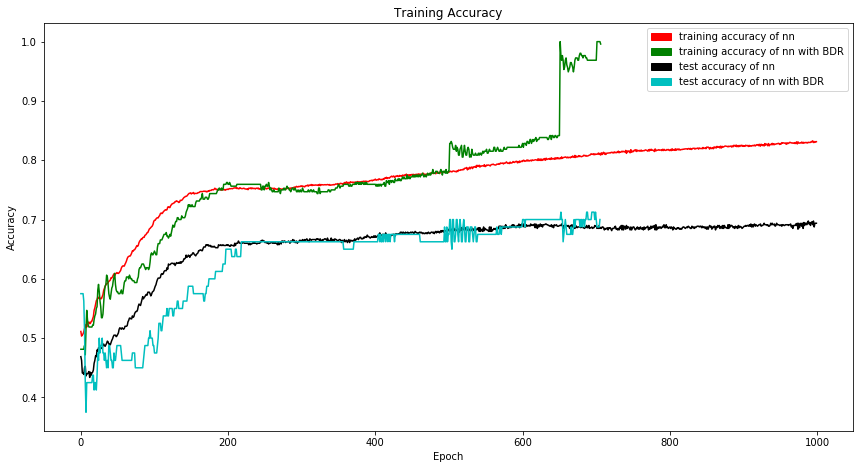

In [16]:

fig, ax = plt.subplots()
a=np.mean(np.array(trainacclist), axis=0)
b=np.mean(np.array(trainacclist2), axis=0)
c=np.mean(np.array(testlist), axis=0)
d=np.mean(np.array(testlist2), axis=0)
plt.plot(range(len(a)),a,c='r')
plt.plot(range(len(b)),b,c='g')
plt.plot(range(len(c)),c,c='k')
plt.plot(range(len(d)),d,c='c')
# ax.axhline(y=sum(acclist)/len(acclist),c='b')
# ax.axhline(y=sum(acclist2)/len(acclist2),c='y')
patch1 = matplotlib.patches.Patch(color='red', label='training accuracy of nn')
patch2 = matplotlib.patches.Patch(color='g', label='training accuracy of nn with BDR')
patch3 = matplotlib.patches.Patch(color='k', label='test accuracy of nn')
patch4 = matplotlib.patches.Patch(color='c', label='test accuracy of nn with BDR')
plt.legend(handles=[patch1,patch2,patch3,patch4])
fig.set_size_inches(14.5, 7.5, forward=True)
plt.xlabel('Epoch') 
        
plt.legend(handles=[patch1,patch2,patch3,patch4])
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

### Run neural network with BDR to get new training datset then feed them into new neural network

In [17]:
# BASIC NORMAL BACKPROGATION
# define the number of neurons for input layer, hidden layer and output layer
# define learning rate and number of epoch on training
# If you remove outliers only from the trainning set, it become harder for the model to learn to accurately predict outliers in the test set
# Try on remove outliers only on trainning set, however, test accuracy much lower then train, because the model only learn from the easy data
# error variance: error, loss function
# nn model sigmoid, ReLU
# Change of loss
# CHange of % of 1 and 0
# Use or no use ID


# PARAMETER FOR NERUAL NETWORK
input_neurons = 6
hidden_neurons = 20
output_neurons = 2
learning_rate = 0.005  #0.005 for better result, remember to changed the one after
num_epoch = 1000

In [18]:
# ACCURACY SCORE LIST FOR EACH RUN
acclist=[]
testlist=[]
# LOSS LIST FOR EACH RUN
losslist=[]
trainacclist=[]
# RUN 10 TIMES FOR AVERAGE SCORE
for run in range(10):
    trainacclist.append([])
    testlist.append([])
    net = torch.nn.Sequential(
        torch.nn.Linear(input_neurons, hidden_neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_neurons, output_neurons),
    )

    # define loss functions
    loss_func = torch.nn.CrossEntropyLoss()

    # define optimiser
    optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # store all losses for visualisation
    all_losses = []
    # train a neural network
    for epoch in range(num_epoch):
        # Perform forward pass: compute predicted y by passing x to the model.
        # Here we pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        # In this case, Y_pred contains three columns, where the index of the
        # max column indicates the class of the instance
        Y_pred = net(X)
        # Compute loss
        # Here we pass Tensors containing the predicted and true values of Y,
        # and the loss function returns a Tensor containing the loss.
        loss = loss_func(Y_pred, Y)
        all_losses.append(loss.item())
        # print progress
#         if epoch % 50 == 0:
            # convert three-column predicted Y values to one column for comparison
        raw_pred, predicted = torch.max(F.softmax(Y_pred,1), 1)

        total = predicted.size(0)
        correct = predicted.data.numpy() == Y.data.numpy()
#             print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
#                   % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))

        # Clear the gradients before running the backward pass.
        net.zero_grad()
        trainacclist[run].append(sum(correct)/total)
        # Perform backward pass: compute gradients of the loss with respect to
        # all the learnable parameters of the model.
        loss.backward()

        # Calling the step function on an Optimiser makes an update to its
        # parameters
        optimiser.step()
        Y_pred = net(X1)
        _, predicted = torch.max(F.softmax(Y_pred,1), 1)
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y1.data.numpy()
        testlist[run].append(sum(correct)/total)
        
    Y_pred = net(X1)

    # Compute loss
    # Here we pass Tensors containing the predicted and true values of Y,
    # and the loss function returns a Tensor containing the loss.
    losslist.append(all_losses)
    _, predicted = torch.max(F.softmax(Y_pred,1), 1)
    # calculate and print accuracy
    total = predicted.size(0)
    correct = predicted.data.numpy() == Y1.data.numpy()
    acclist.append(sum(correct)/total)
    print('Normal backprogation result Accuracy: %.2f %%'
          % (100 * sum(correct)/total))
print("Average accuracy: %.6f"%(sum(acclist)/len(acclist)))

Normal backprogation result Accuracy: 70.00 %
Normal backprogation result Accuracy: 70.00 %
Normal backprogation result Accuracy: 70.00 %
Normal backprogation result Accuracy: 67.50 %
Normal backprogation result Accuracy: 68.75 %
Normal backprogation result Accuracy: 63.75 %
Normal backprogation result Accuracy: 65.00 %
Normal backprogation result Accuracy: 66.25 %
Normal backprogation result Accuracy: 65.00 %
Normal backprogation result Accuracy: 71.25 %
Average accuracy: 0.68


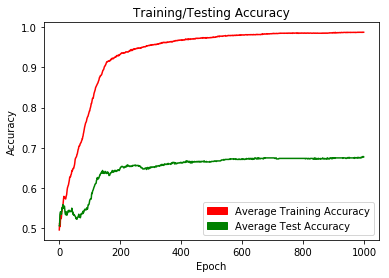

In [19]:
fig, ax = plt.subplots()
a=np.mean(np.array(trainacclist), axis=0)
b=np.mean(np.array(testlist), axis=0)
plt.plot(range(len(a)),a,c='r')
plt.plot(range(len(b)),b,c='g')
plt.xlabel('Epoch') 
# ax.axhline(y=sum(acclist)/len(acclist))
        
patch1 = matplotlib.patches.Patch(color='r', label='Average Training Accuracy')
patch2 = matplotlib.patches.Patch(color='g', label='Average Test Accuracy')
plt.legend(handles=[patch1,patch2])
# fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Accuracy')
plt.title('Training/Testing Accuracy')
plt.show()

### apply BDR on all dataset before seperate into test and train set. After that, we split into test and train set and run normal back propagation on the resulting dataset.

In [20]:
# USE ALL DATA FOR BDR
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0, random_state=0)

X_train_array = X_train.values
y_train_array = np.array([i[0] for i in y_train.values])
x_array = X_train_array
y_array = y_train_array
X = torch.tensor(x_array, dtype=torch.float)
Y = torch.tensor(y_array, dtype=torch.long)

In [21]:

# define the number of neurons for input layer, hidden layer and output layer
# define learning rate and number of epoch on training
input_neurons = 6
hidden_neurons = 20
output_neurons = 2
learning_rate = 0.005
num_epoch = 2000
alpha_value=0.5

In [22]:
net = torch.nn.Sequential(
    torch.nn.Linear(input_neurons, hidden_neurons),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_neurons, output_neurons),
)

# define loss functions
loss_func = torch.nn.CrossEntropyLoss()

# define optimiser
optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate)

0.20514716596030255
Epoch [1/2000] Loss: 0.6970  Accuracy: 50.25 %
0.18089818548897227
Epoch [51/2000] Loss: 0.6796  Accuracy: 56.50 %
0.14640203113839553
Epoch [101/2000] Loss: 0.6411  Accuracy: 65.50 %
0.11771574504894547
Epoch [151/2000] Loss: 0.5859  Accuracy: 71.50 %
0.11390305980276104
Epoch [201/2000] Loss: 0.5403  Accuracy: 72.00 %
0.11393672753691078
Epoch [251/2000] Loss: 0.5137  Accuracy: 71.75 %
0.11369931298449806
Epoch [301/2000] Loss: 0.4994  Accuracy: 71.75 %
0.11072970594717235
Epoch [351/2000] Loss: 0.4905  Accuracy: 73.25 %
0.11039707224016272
Epoch [401/2000] Loss: 0.4830  Accuracy: 73.25 %
0.10958050388914022
Epoch [451/2000] Loss: 0.4774  Accuracy: 73.75 %
0.11078025789023638
Epoch [501/2000] Loss: 0.4730  Accuracy: 73.25 %
0.11086926739424185
Epoch [551/2000] Loss: 0.4658  Accuracy: 75.25 %
0.11260823717084552
Epoch [601/2000] Loss: 0.4613  Accuracy: 75.00 %
0.11229760082072339
Epoch [651/2000] Loss: 0.4583  Accuracy: 75.25 %
0.11094533405131969
Epoch [701/2000] 

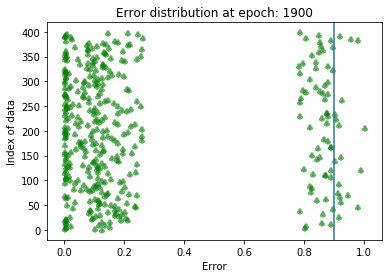

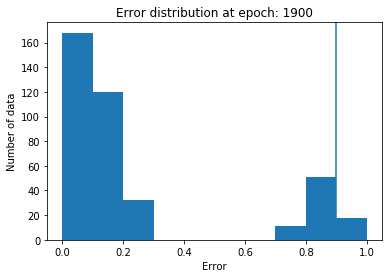

new Data length:  382
Epoch [1901/2000] Loss: 0.4034  Accuracy: 80.00 %
0.09708578505308843
<0.1 trigger at:  1950


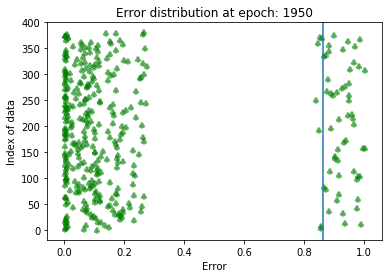

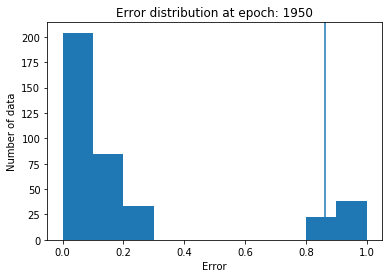

new Data length:  330
Epoch [1951/2000] Loss: 0.3296  Accuracy: 84.29 %


In [23]:
#Normal backprogation with BDR
# store all losses for visualisation
all_losses = []
all_vari=[]
triggerpoint=[]
errdistribute=[]
# train a neural network
for epoch in range(num_epoch):
    # Perform forward pass: compute predicted y by passing x to the model.
    # Here we pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    # In this case, Y_pred contains three columns, where the index of the
    # max column indicates the class of the instance
    Y_pred = net(X)
    # Compute loss
    # Here we pass Tensors containing the predicted and true values of Y,
    # and the loss function returns a Tensor containing the loss.
    loss = loss_func(Y_pred, Y)
    
    all_losses.append(loss.item())
    
    # print progress

    # convert three-column predicted Y values to one column for comparison
    raw_pred, predicted = torch.max(F.softmax(Y_pred,1), 1)

    # calculate and print accuracy
    total = predicted.size(0)
    correct = predicted.data.numpy() == Y.data.numpy()

    pred=[i.item() for i in raw_pred]

    x=np.array([[-abs(pred[i])] if correct[i] else [abs(pred[i])] for i in range(len(correct))])
### BELOW ARE USING LOSS FUNCTION AS ERROR VARIANCE
#     x=[]
#     for i in range(len(Y)):
#         x.append([loss_func(Y_pred[i:i+1],Y[i:i+1]).item()])
    
    df = pd.DataFrame(x*1)
    for column in df.columns:
        df[column] = df.loc[:, [column]].apply(lambda x: (x - x.min()) / (x.max()- x.min()))
#         df[column] = df.loc[:, [column]].apply(lambda x: (x - x.mean()) / x.std())
    errorlist=[i for i in df[0].values]
    errdistribute.append(errorlist)
    vari=np.var(errorlist)
    all_vari.append(vari)
    if vari<=0.01:
        print("<=0.01 Stop trigger at: ",epoch)
        break
    if (epoch) % 50 == 0:
        print(vari)
        if vari<0.1:
            print("<0.1 trigger at: ",epoch)
            triggerpoint.append((vari,epoch))
            meanerror=np.mean(errorlist)
            masklist=[]
#             masklist=[0 if i>meanerror else 1 for i in errorlist]
            sublist=[i if i>meanerror else 0 for i in errorlist]
            sublist_cal=[i for i in errorlist if i>meanerror]
            sublist_cal_mean=np.mean(np.array(sublist_cal))
            sublist_cal_std=np.std(np.array(sublist_cal))
#             print(sublist_cal)
            for i in range(len(errorlist)):
                if errorlist[i]>=sublist_cal_mean+alpha_value*sublist_cal_std:
                    masklist.append(0)
                else:
                    masklist.append(1)
            fig, ax = plt.subplots()
            plt.scatter(errorlist,[i for i in range(len(errorlist))], c="g", alpha=0.5, marker=r'$\clubsuit$',label="Luck")
            ax.axvline(x=sublist_cal_mean+alpha_value*sublist_cal_std)
            plt.title('Error distribution at epoch: '+str(epoch))
            plt.xlabel('Error')
            plt.ylabel('Index of data')
            plt.show()
            fig, ax = plt.subplots()
            plt.hist(errorlist)
            ax.axvline(x=sublist_cal_mean+alpha_value*sublist_cal_std)
            plt.xlabel('Error')
            plt.ylabel('Number of data')
            plt.title('Error distribution at epoch: '+str(epoch))
            plt.show()
            loc = torch.ByteTensor(masklist)
#             break
            X = X[loc]
            Y = Y[loc]
            normalized_test_Y=[i.item() for i in Y]
            print("new Data length: ",len(X))
            
        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
          % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))
#         print(int(sum(Y))/len(Y))
        
    # Clear the gradients before running the backward pass.
    net.zero_grad()

    # Perform backward pass: compute gradients of the loss with respect to
    # all the learnable parameters of the model.
    loss.backward()

    # Calling the step function on an Optimiser makes an update to its
    # parameters
    optimiser.step()

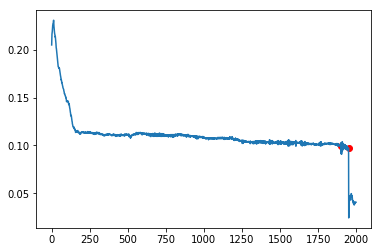

In [24]:
fig, ax = plt.subplots()
plt.plot(all_vari)
xxx=[]
yyy=[]
for a,b in triggerpoint:
    xxx.append(a)
    yyy.append(b)
plt.scatter(yyy,xxx,c='r')
plt.show()

In [25]:
# USE THE NEW DATA AND SPLIT INTO TEST AND TRAIN INTO NORMAL BACK PROPAGATION
X_train, X_test, y_train, y_test = train_test_split(X.data.numpy(), Y.data.numpy(), test_size=0.2, random_state=0)

x_array = X_train
x1_array = X_test
y_array = y_train
y1_array = y_test

In [26]:
# BASIC NORMAL BACKPROGATION
# define the number of neurons for input layer, hidden layer and output layer
# define learning rate and number of epoch on training
# If you remove outliers only from the trainning set, it become harder for the model to learn to accurately predict outliers in the test set
input_neurons = 6
hidden_neurons = 20
output_neurons = 2
learning_rate = 0.005
num_epoch = 2000

In [27]:
# define the structure of our neural network
acclist=[]
trainacclist=[]
testlist=[]
losslist=[]
for run in range(10):
    X = torch.tensor(x_array, dtype=torch.float)
    Y = torch.tensor(y_array, dtype=torch.long)
    X1 = torch.tensor(x1_array, dtype=torch.float)
    Y1 = torch.tensor(y1_array, dtype=torch.long)
    net = torch.nn.Sequential(
        torch.nn.Linear(input_neurons, hidden_neurons),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_neurons, output_neurons),
    )
    testlist.append([])
    trainacclist.append([])
    # define loss functions
    loss_func = torch.nn.CrossEntropyLoss()

    # define optimiser
    optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # store all losses for visualisation
    all_losses = []
    # train a neural network
    for epoch in range(num_epoch):
        # Perform forward pass: compute predicted y by passing x to the model.
        # Here we pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        # In this case, Y_pred contains three columns, where the index of the
        # max column indicates the class of the instance
        Y_pred = net(X)
        # Compute loss
        # Here we pass Tensors containing the predicted and true values of Y,
        # and the loss function returns a Tensor containing the loss.
        loss = loss_func(Y_pred, Y)
        all_losses.append(loss.item())
        # print progress
#         if epoch % 50 == 0:
            # convert three-column predicted Y values to one column for comparison
        raw_pred, predicted = torch.max(F.softmax(Y_pred,1), 1)

        total = predicted.size(0)
        correct = predicted.data.numpy() == Y.data.numpy()
#             print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
#                   % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))
        trainacclist[run].append(sum(correct)/total)
        # Clear the gradients before running the backward pass.
        net.zero_grad()

        # Perform backward pass: compute gradients of the loss with respect to
        # all the learnable parameters of the model.
        loss.backward()

        # Calling the step function on an Optimiser makes an update to its
        # parameters
        optimiser.step()
        Y_pred = net(X1)
        _, predicted = torch.max(F.softmax(Y_pred,1), 1)
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y1.data.numpy()
        testlist[run].append(sum(correct)/total)
    Y_pred = net(X1)

    # Compute loss
    # Here we pass Tensors containing the predicted and true values of Y,
    # and the loss function returns a Tensor containing the loss.
    losslist.append(all_losses)
    _, predicted = torch.max(F.softmax(Y_pred,1), 1)
#     print(Y1)
#     print(predicted)
    # calculate and print accuracy
    total = predicted.size(0)
    correct = predicted.data.numpy() == Y1.data.numpy()
    acclist.append(sum(correct)/total)
    print('Normal backprogation result Accuracy: %.2f %%'
          % (100 * sum(correct)/total))
print("Average accuracy: %.6f"%(sum(acclist)/len(acclist)))

Normal backprogation result Accuracy: 90.91 %
Normal backprogation result Accuracy: 90.91 %
Normal backprogation result Accuracy: 84.85 %
Normal backprogation result Accuracy: 89.39 %
Normal backprogation result Accuracy: 89.39 %
Normal backprogation result Accuracy: 89.39 %
Normal backprogation result Accuracy: 92.42 %
Normal backprogation result Accuracy: 89.39 %
Normal backprogation result Accuracy: 87.88 %
Normal backprogation result Accuracy: 89.39 %
Average accuracy: 0.89


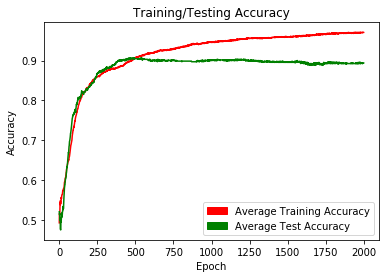

In [28]:
fig, ax = plt.subplots()
a=np.mean(np.array(trainacclist), axis=0)
b=np.mean(np.array(testlist), axis=0)
plt.plot(range(len(a)),a,c='r')
plt.plot(range(len(b)),b,c='g')
plt.xlabel('Epoch') 
# ax.axhline(y=sum(acclist)/len(acclist))
        
patch1 = matplotlib.patches.Patch(color='r', label='Average Training Accuracy')
patch2 = matplotlib.patches.Patch(color='g', label='Average Test Accuracy')
plt.legend(handles=[patch1,patch2])
# fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Accuracy')
plt.title('Training/Testing Accuracy')
plt.show()